In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import procyclingstats as pcs
import os

In [2]:
def get_riders_tdf(season):
    url_startlist = f"https://www.procyclingstats.com/race/tour-de-france/{season}/startlist"
    page = requests.get(url_startlist)
    soup = BeautifulSoup(page.content, "html.parser")
    riders = []
    #FIXME There is a bug here, more stuff is being taken
    for a in soup.find_all("a", href=True):
        href = a['href']
        if href.startswith('rider/'):
            rider = href[6:]
            riders.append(rider)
    return riders

In [14]:
def get_rider_results(rider, season):
    url = f"rider.php?xseason={season}&zxseason=&pxseason=equal&sort=date&race=&km1=&zkm1=&pkm1=equal&limit=200&topx=&ztopx=&ptopx=smallerorequal&type=&znation=&continent=&pnts=&zpnts=&ppnts=equal&level=&rnk=&zrnk=&prnk=equal&exclude_tt=0&racedate=&zracedate=&pracedate=equal&name=&pname=contains&category=&profile_score=&zprofile_score=&pprofile_score=largerorequal&filter=Filter&id={rider}&p=results&s=all"
#     return pcs.RiderResults(url).results('rank', 'stage_name', 'pcs_points')
    filename = f'rider_data/{rider}_{season}.csv.gz'
    if os.path.exists(filename):
        df = pd.read_csv(filename, index_col=0)
    else:
        df = pd.DataFrame(pcs.RiderResults(url).results())#'rank', 'stage_name', 'distance'))
        df['stage_name'] = f"{season} " + df['stage_name']
        df.to_csv(filename)
    return df

In [34]:
get_rider_results('wilco-kelderman', 2021)


,date,rank,stage_url,stage_name,nationality,class,distance,pcs_points,uci_points
0,2021-09-01,NaN,race/renewi-tour/2021/stage-3,2021 Benelux Tour | Stage 3,BE,2.UWT,168.3,0,0.0
1,2021-08-31,33.0,race/renewi-tour/2021/stage-2,2021 Benelux Tour | Stage 2 (ITT),BE,2.UWT,11.1,0,0.0
2,2021-08-30,18.0,race/renewi-tour/2021/stage-1,2021 Benelux Tour | Stage 1,BE,2.UWT,169.6,0,0.0
3,2021-08-01,40.0,race/circuito-de-getxo/2021/result,2021 Circuito de Getxo - Memorial Hermanos Otxoa,ES,1.1,193.5,0,0.0
4,2021-07-31,NaN,race/san-sebastian/2021/result,2021 Donostia San Sebastian Klasikoa,ES,1.UWT,223.5,0,0.0
...,...,...,...,...,...,...,...,...,...
57,2021-03-26,45.0,race/volta-a-catalunya/2021/stage-5,2021 Volta Ciclista a Catalunya | Stage 5,ES,2.UWT,201.1,0,0.0
58,2021-03-25,8.0,race/volta-a-catalunya/2021/stage-4,2021 Volta Ciclista a Catalunya | Stage 4,ES,2.UWT,166.5,3,0.0
59,2021-03-24,14.0,race/volta-a-catalunya/2021/stage-3,2021 Volta Ciclista a Catalunya | Stage 3,ES,2.UWT,203.1,0,0.0
60,2021-03-23,12.0,race/volta-a-catalunya/2021/stage-2,2021 Volta Ciclista a Catalunya | Stage 2 (ITT),ES,2.UWT,18.5,0,0.0


In [35]:
def get_mean_pcs_points_rank(df):
    df_ = df[~df['stage_name'].str.contains('Tour de France')]
    return np.mean(df_['pcs_points'])/np.mean(df_['rank'])

def get_rider_stats(rider, season):
    
    results_0 = get_rider_results(rider, season)
    results_1 = get_rider_results(rider, season-1)
    results_2 = get_rider_results(rider, season-2)

    score_0 = get_mean_pcs_points_rank(results_0)
    score_1 = get_mean_pcs_points_rank(results_1)
    score_2 = get_mean_pcs_points_rank(results_2)

    tdf_0 = results_0[results_0['stage_name'].str.contains('Tour de France')]
    
    if not tdf_0.empty:
        try:
            rank_gc = tdf_0[tdf_0['stage_name'] == f'{season} Tour de France']['rank'].iloc[0]
        except (KeyError, IndexError):
            rank_gc = np.nan
        try:
            rank_points = tdf_0[tdf_0['stage_name'] == f'{season} Tour de France | Points classification']['rank'].iloc[0]
        except (KeyError, IndexError):
            rank_points = np.nan
        try:
            rank_mount = tdf_0[tdf_0['stage_name'] == f'{season} Tour de France | Mountains classification']['rank'].iloc[0]
        except (KeyError, IndexError):
            rank_mount = np.nan
        try:
            rank_youth = tdf_0[tdf_0['stage_name'] == f'{season} Tour de France | Youth classification']['rank'].iloc[0]
        except (KeyError, IndexError):
            rank_youth = np.nan

        stages = tdf_0[tdf_0['stage_name'].str.contains('Stage')]
        ranks = stages['rank']
        stages_mean = np.nanmean(ranks)
        stages_min = np.nanmin(ranks)
        stages_med = np.nanmedian(ranks)
    else:
        rank_gc, rank_mount, rank_youth, rank_points, stages_mean, stages_med, stages_min = 7 * (np.nan, )
        
    #TODO should save col names somewhere
    return score_0, score_1, score_2, rank_gc, rank_points, rank_mount, rank_youth, stages_mean, stages_min, stages_med
        

def get_all_data_from_riders(season, nX=3, ny=7):
    riders = get_riders_tdf(season)
    nriders = len(riders)
    X = np.zeros((nriders, nX+ny))

    for i, rider in enumerate(riders):
        try:
            X[i] = get_rider_stats(rider, season)
        except:
            X[i] = (nX+ny) * [np.nan]
    return X, riders



In [36]:
get_rider_stats('wilco-kelderman', 2021)

(0.545957284515637,
 0.8730305838739575,
 0.28145256055494483,
 5.0,
 23.0,
 24.0,
 nan,
 25.285714285714285,
 4.0,
 25.0)

In [37]:
for year in range(2000, 2024):
    print(year)
    X, riders = get_all_data_from_riders(year)
    np.savez(f'data_{year}.npz', X=X, riders=riders)

2000


/tmp/ipykernel_218855/32953284.py:38: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/tmp/ipykernel_218855/32953284.py:39: RuntimeWarning: All-NaN axis encountered
  stages_min = np.nanmin(ranks)
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/tmp/ipykernel_218855/32953284.py:38: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/tmp/ipykernel_218855/32953284.py:39: RuntimeWarning: All-NaN axis encountered
  stages_min = np.nanmin(ranks)
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/tmp/ipykernel_218855/32953284.py:38: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/tmp/ipykernel_218855/32953284.py:39: Runtim

2001


/tmp/ipykernel_218855/32953284.py:38: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/tmp/ipykernel_218855/32953284.py:39: RuntimeWarning: All-NaN axis encountered
  stages_min = np.nanmin(ranks)
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


2002
2003
2004


/tmp/ipykernel_218855/32953284.py:38: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/tmp/ipykernel_218855/32953284.py:39: RuntimeWarning: All-NaN axis encountered
  stages_min = np.nanmin(ranks)
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


2005
2006
2007


/tmp/ipykernel_218855/32953284.py:38: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/tmp/ipykernel_218855/32953284.py:39: RuntimeWarning: All-NaN axis encountered
  stages_min = np.nanmin(ranks)
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


2008


/tmp/ipykernel_218855/32953284.py:38: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/tmp/ipykernel_218855/32953284.py:39: RuntimeWarning: All-NaN axis encountered
  stages_min = np.nanmin(ranks)
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


2009
2010


/tmp/ipykernel_218855/32953284.py:38: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/tmp/ipykernel_218855/32953284.py:39: RuntimeWarning: All-NaN axis encountered
  stages_min = np.nanmin(ranks)
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/tmp/ipykernel_218855/32953284.py:38: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/tmp/ipykernel_218855/32953284.py:39: RuntimeWarning: All-NaN axis encountered
  stages_min = np.nanmin(ranks)
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


2011
2012
2013
2014


/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_218855/32953284.py:38: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)


2015
2016


/tmp/ipykernel_218855/32953284.py:38: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)


2017


/tmp/ipykernel_218855/32953284.py:38: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/tmp/ipykernel_218855/32953284.py:39: RuntimeWarning: All-NaN axis encountered
  stages_min = np.nanmin(ranks)
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/tmp/ipykernel_218855/32953284.py:38: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/tmp/ipykernel_218855/32953284.py:39: RuntimeWarning: All-NaN axis encountered
  stages_min = np.nanmin(ranks)
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/tmp/ipykernel_218855/32953284.py:38: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/tmp/ipykernel_218855/32953284.py:38: Runtim

2018


/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2019


/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_218855/32953284.py:38: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2020


/tmp/ipykernel_218855/32953284.py:38: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/tmp/ipykernel_218855/32953284.py:39: RuntimeWarning: All-NaN axis encountered
  stages_min = np.nanmin(ranks)
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/tmp/ipykernel_218855/32953284.py:38: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/tmp/ipykernel_218855/32953284.py:38: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/tmp/ipykernel_218855/32953284.py:38: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)


2021


/tmp/ipykernel_218855/32953284.py:38: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/tmp/ipykernel_218855/32953284.py:39: RuntimeWarning: All-NaN axis encountered
  stages_min = np.nanmin(ranks)
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/tmp/ipykernel_218855/32953284.py:38: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/tmp/ipykernel_218855/32953284.py:39: RuntimeWarning: All-NaN axis encountered
  stages_min = np.nanmin(ranks)
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/tmp/ipykernel_218855/32953284.py:38: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/tmp/ipykernel_218855/32953284.py:39: Runtim

2022
2023


In [627]:
Xs = []
ys = []
riderss = []
for year in range(2000, 2022):
    data = np.load(f'data_{year}.npz')
    X = data['X']
    riders = data['riders']
    X, y = X[:, :3], X[:, 8]
    Xs.append(X)
    ys.append(y)
    riderss.append(riders)

    
eps = 1e-3
X = np.vstack(Xs)
y = np.hstack(ys)
mask = np.isfinite(y)
X = X[mask]
y = np.log(y[mask]+eps)
riders = np.hstack(riderss)
riders = riders[mask]

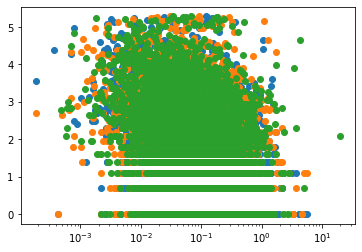

In [628]:
plt.scatter(X[:, 0], y)
plt.scatter(X[:, 1], y)
plt.scatter(X[:, 2], y)
plt.xscale('log')

In [629]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

def func(x):
    return np.log(x+eps)

pipe = Pipeline([('imp', SimpleImputer()),
                 ('log', FunctionTransformer(func)),
#                  ('poly', PolynomialFeatures(3, include_bias=False)),
#                  ('reg', LinearRegression())])
                 ('reg', SVR(kernel='rbf'))])
                 
                 
        

pipe.fit(X, y)
pipe.score(X, y)

0.23383711161263188

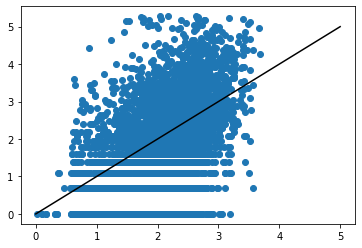

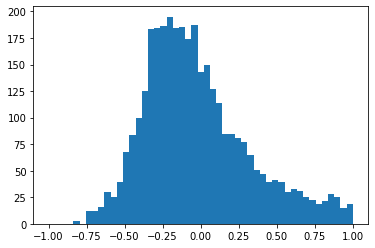

In [630]:
y_pred = pipe.predict(X)
plt.scatter(y_pred, y)
# plt.xlim([0, 100])
# plt.ylim([0, 100])
plt.plot([0, 5], [0, 5], 'k-')
plt.figure()
plt.hist(y_pred/y-1, bins=np.linspace(-1, 1));


In [631]:
data_2023 = np.load('data_2023.npz')
X_2023 = data_2023['X'][:, :3]
riders_2023 = data_2023['riders']
pred_2023 = pipe.predict(X_2023)
riders_2023, unique_i = np.unique(riders_2023, return_index=True)
pred_2023 = np.exp(pred_2023[unique_i])
# arg_sort = np.argsort(pred_2023)
# pred_2023_sort = pred_2023[arg_sort]
# riders_sort = riders_2023[arg_sort]
# for r, p in zip(riders_sort[:20], pred_2023_sort[:20]):
#     print(r, p)

In [632]:
df = pd.DataFrame({'rider': riders_2023, 'pred': pred_2023}).sort_values('pred')
df.head(20)

,rider,pred
142,remco-evenepoel,1.568843
79,jonas-vingegaard-rasmussen,1.573285
47,elisa-longo-borghini,1.768852
30,christophe-laporte,1.848164
0,adam-yates,1.960073
71,jasper-philipsen,1.968404
85,katarzyna-niewiadoma,2.000591
103,matej-mohoric,2.061149
105,mathieu-van-der-poel,2.073083
159,stefan-kung,2.087978


In [643]:
def get_rider_pred(substr):
    df_ = df[df['rider'].str.contains(substr)]
    print(df_['rider'].iloc[0], df_['pred'].iloc[0])

get_rider_pred('meeus')
get_rider_pred('groenewegen')
get_rider_pred('girmay')
get_rider_pred('coquard')
get_rider_pred('cavendish')
get_rider_pred('philipsen')
get_rider_pred('bauhaus')
get_rider_pred('sagan')
get_rider_pred('mozz')
get_rider_pred('poppel')
get_rider_pred('aranburu')

jordi-meeus 7.596977857238578
dylan-groenewegen 6.633956017319044
biniam-girmay 4.782211675871619
bryan-coquard 6.197760831135707
mark-cavendish 7.03428372906208
jasper-philipsen 1.968403849225289
phil-bauhaus 8.081171639094123
peter-sagan 7.000493580292714
luca-mozzato 6.775199320331096
danny-van-poppel 6.6550387908550075
alex-aranburu 4.775035929489881


In [639]:
get_rider_pred('connor')
get_rider_pred('bardet')
get_rider_pred('gaudu')
get_rider_pred('meintjes')
get_rider_pred('guillaume-martin')
get_rider_pred('landa')
get_rider_pred('rodriguez')
get_rider_pred('enric-mas')
get_rider_pred('bilbao')

ben-o-connor 3.516959352246041
romain-bardet 2.7386747223610324
david-gaudu 2.54766382317265
louis-meintjes 7.352675732118217
guillaume-martin 3.4540433332549183
mikel-landa 2.616078576234091
carlos-rodriguez-cano 2.3598469294549704
enric-mas 2.5880428384744936
pello-bilbao 2.128131615482733


In [638]:
get_rider_pred('van-der-poel')
get_rider_pred('powless')
get_rider_pred('pidcock')
get_rider_pred('alaphi')
get_rider_pred('cicco')

mathieu-van-der-poel 2.073082823269829
neilson-powless 2.3716065345836217
thomas-pidcock 2.0880984344744298
julian-alaphilippe 4.2443937580948825
giulio-ciccone 2.1222239598953165


In [ ]:
a yates, mohoric, kung, bilbao, s yates, rodriguez, laporte, mvdwp, wva, pidcock